# Local dynamics
Here, we explore how phosphorylation changes local fluctuations (as predicted by NMA)

## Amplitude of local fluctuations differences
First, we estimate a threshold above which a difference in fluctuations can be considered significant

In [192]:
from pathlib import Path
import numpy as np
import pandas as pd

from collections import defaultdict
from scipy.stats import wilcoxon
from scipy.signal import find_peaks
from itertools import combinations, product
from statsmodels.stats.multitest import multipletests
from collections import Counter

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

def pad_array(arr):
    """
    Pad array with zeros at the beginning and the end
    """
    padded_arr = np.insert(arr,0,0)
    padded_arr = np.append(arr,0)    
    return padded_arr
    
def find_absolute_peaks(arr,height=None):
    """
    Find the indexes of peaks in the absolute values of the array.
    Should call pad_array() before in order to find peaks at the
    start and beginning of the signal
    """
    abs_arr = np.abs(arr)
    abs_peak_idxs = find_peaks(abs_arr,height)
    abs_peak_idxs = list(abs_peak_idxs[0])
    return abs_peak_idxs

out_path = Path("peak_cutoff_height")
out_path.mkdir(exist_ok=True)

In [193]:
# Raw NMA results
nma_raw_path = Path("../results/nma_analysis_per_psite")
# Processed NMA results
nma_proc_path = Path("../results/nma_per_psite_processed")
# Protein annotation
annot_path = Path("../data/processed/pdb_pairs/chains_by_protein/annotation_per_psite")

psite_to_annotation = {}
psite_to_fluctuation = {}

nma_proc_subdirs = [x for x in nma_proc_path.iterdir() if x.is_dir() and any(x.iterdir())]
valid_stems = [x.stem for x in nma_proc_subdirs] 
nma_raw_subdirs = [x for x in nma_raw_path.iterdir() if (x.is_dir() and x.stem in valid_stems)]

annot_files = [x for x in annot_path.iterdir() if x.stem in valid_stems]


In [194]:
# Associate each phosphosite with its corresponding annotation dataframe
for annot_file in annot_files:
    psite_name = annot_file.stem
    annot_df = pd.read_csv(annot_file, index_col=0)
    psite_to_annotation[psite_name] = annot_df

pdb_chain_to_status = {}
pdb_chain_to_psite = {}

for psite, annot_df  in psite_to_annotation.items():
    for idx, row in annot_df.iterrows():
        pdb_id = row["Full ID"]
        status = row["Status"]
        pdb_chain_to_status[pdb_id] = status
        pdb_chain_to_psite[pdb_id] = psite

In [195]:
for subdir in nma_proc_subdirs:
        
    psite_name = subdir.stem
    raw_dir = nma_raw_path / psite_name
    flucts_df = pd.read_csv(raw_dir / "fluctuation_data.csv",index_col=0)
    psite_to_fluctuation[psite_name] = flucts_df


In [196]:
psite_to_p_chains = defaultdict(list)
psite_to_np_chains = defaultdict(list)
for psite, fluctuation_df in psite_to_fluctuation.items():
    for pdb_chain in fluctuation_df.index:
        pdb_name = pdb_chain.replace(".pdb","")
        status = pdb_chain_to_status[pdb_name]
        if status == "Non-phosphorylated":
            psite_to_np_chains[psite].append(pdb_name)
        elif status == "Phosphorylated":
            psite_to_p_chains[psite].append(pdb_name)
        else:
            raise ValueError(f"Inconsistent state {status}")
        

In [197]:
flucts_df = pd.read_csv("global_dynamics_overview/fluctuations_df_nodups.csv")
psites_nodups = list(flucts_df["phosphosite"])

In [198]:
psite_to_peak_heights = []
columns = ['phosphosite','chain_p','chain_np','peak_height','peak_index']
for psite in psite_to_p_chains:
    if psite in psites_nodups: 
        fluctuation_df = psite_to_fluctuation[psite]
        p_chains = psite_to_p_chains[psite]
        np_chains = psite_to_np_chains[psite]
        combs = list(product(p_chains,np_chains))
        for comb in combs:
            p_chain, np_chain = comb
            flucts_p = fluctuation_df.loc[f"{p_chain}.pdb"].values
            flucts_np = fluctuation_df.loc[f"{np_chain}.pdb"].values

            diffs = flucts_p - flucts_np
            padded_diffs = pad_array(diffs)
            abs_peak_idxs = find_absolute_peaks(padded_diffs)

            for peak_idx in abs_peak_idxs:
                peak_height = np.abs(padded_diffs[peak_idx])
                row = [psite, p_chain, np_chain, peak_height, peak_idx]
                psite_to_peak_heights.append(row)

psite_to_peak_heights = pd.DataFrame(psite_to_peak_heights,columns=columns)


In [199]:
psite_to_peak_heights.to_csv(out_path / 'psite_to_peak_heights.csv')

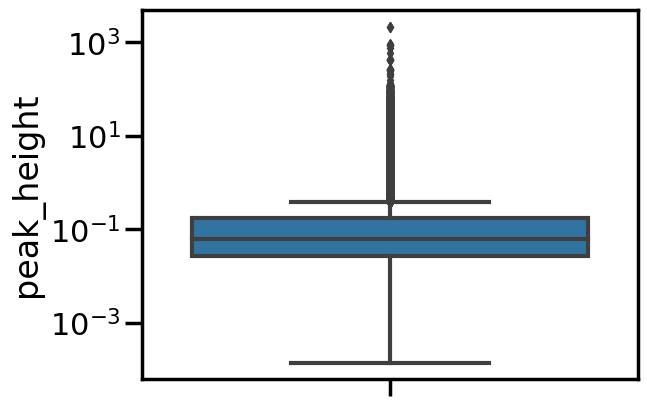

In [200]:
# Visualize distribution of all detected peaks
sns.boxplot(data=psite_to_peak_heights, y="peak_height")
plt.yscale('log')
plt.savefig(out_path / "boxplot_diff_peak_heights.png",bbox_inches='tight',dpi=120)

In [202]:
# Filter out outliers using the IQR rule
q1=psite_to_peak_heights.peak_height.quantile(0.25)
q3=psite_to_peak_heights.peak_height.quantile(0.75)
iqr=q3-q1
not_outliers = psite_to_peak_heights.loc[~((psite_to_peak_heights["peak_height"]<(q1-1.5*iqr)) | (psite_to_peak_heights["peak_height"]>(q3+1.5*iqr)))]

# Select a cutoff
cutoff = not_outliers["peak_height"].median() + 6*not_outliers["peak_height"].std()
print("Selected cutoff at median + 6 standard deviations")
print(cutoff)


Selected cutoff at median + 6 standard deviations
0.5530458571703001


In [203]:
signal = psite_to_peak_heights.loc[psite_to_peak_heights["peak_height"] > cutoff]
print("What fraction of all peaks are we selecting?")
print(len(signal) / len(psite_to_peak_heights))

What fraction of all peaks are we selecting?
0.09848737761972241


In [204]:
signal.sort_values(by="peak_height")

,phosphosite,chain_p,chain_np,peak_height,peak_index
1020163,P25321_11,6yps_A,5lcp_A,0.553049,38
1303560,P25321_140,6yps_A,5lcp_A,0.553049,38
969447,P25321_11,5ot3_A,5lcq_A,0.553062,200
1252844,P25321_140,5ot3_A,5lcq_A,0.553062,200
1343391,P01112_64,8cnn_A,7jif_A,0.553065,32
...,...,...,...,...,...
848946,Q16594_8,6f3t_L,7egg_I,877.016189,107
848921,Q16594_8,6f3t_J,7egg_I,889.733548,107
848897,Q16594_8,6f3t_H,7egg_I,911.593378,107
170016,Q61686_13,2rvm_A,2rvl_A,2088.535329,3


# Differences between phosphorylated and non-phosphorylated proteins

In [207]:
p_fluctuations = defaultdict(list)
np_fluctuations = defaultdict(list)

nma_raw_subdirs = [x for x in nma_raw_subdirs if x.stem in psites_nodups]
for subdir in nma_raw_subdirs:
    psite = subdir.stem
    flucts_df = psite_to_fluctuation[psite]
    
    for idx, row in flucts_df.iterrows():
        pdb_chain = row.name.split(".")[0]
        fluctuations = row.values
        status = pdb_chain_to_status[pdb_chain]
        if status == "Non-phosphorylated":
            np_fluctuations[psite].append(row.values)
        elif status == "Phosphorylated":
            p_fluctuations[psite].append(row.values)
        else:
            raise ValueError(f"Unknown status for chain {pdb_chain}")

print(f"Retrieved {len(p_fluctuations.keys())}")
print(f"Retrieved {len(np_fluctuations.keys())}")

Retrieved 128
Retrieved 128


In [208]:
psite_peaks = []
columns = ['phosphosite','peak_height']

for psite in p_fluctuations.keys():
    
    p_sqflucts = p_fluctuations[psite]
    np_sqflucts = np_fluctuations[psite]
        
    if len(p_sqflucts) > 0 and len(np_sqflucts) > 0:
        
        # Take the median fluctuations in the phosphorylated set
        # and the non-phosphorylated set
        p_local_medians = np.median(np.vstack(p_sqflucts), axis=0)
        np_local_medians = np.median(np.vstack(np_sqflucts), axis=0)
        diffs = p_local_medians - np_local_medians
                
        padded_diffs = pad_array(diffs)
        abs_peak_idxs = find_absolute_peaks(padded_diffs, height=cutoff)
        
        for peak_idx in abs_peak_idxs:
            peak_height = padded_diffs[peak_idx]
            if abs(peak_height) > cutoff:
                #print(psite, peak_height)
                row = [psite, peak_height]
                psite_peaks.append(row)

psite_peaks = pd.DataFrame(psite_peaks, columns=columns)

In [209]:
# How many peaks per protein?
psite_to_peak_heights = defaultdict(list)
for idx, row in psite_peaks.iterrows():
    psite = row['phosphosite']
    peak_height = row['peak_height']
    psite_to_peak_heights[psite].append(peak_height)

In [210]:
# Median peak height per phosphosite?
psite_to_median_peak_height = {}
for k,v in psite_to_peak_heights.items():
    psite_to_median_peak_height[k] = np.median(v)

In [211]:
# How many peaks per phosphosite?
psite_to_number_of_peaks = {}
for k,v in psite_to_peak_heights.items():
    psite_to_number_of_peaks[k] = len(v)

# Add phosphosites with no significant peaks
missing_peaks = set(psites_nodups).difference(set(psite_to_median_peak_height.keys()))
for psite in missing_peaks:
    psite_to_number_of_peaks[psite] = 0
print(f"{len(missing_peaks)} phosphosites have no significant peaks")

22 phosphosites have no significant peaks


In [218]:
#psite_to_number_of_peaks

In [246]:
0 in peak_number_per_psite

True

In [241]:
median_peak_height_per_psite = list(psite_to_median_peak_height.values())
peak_number_per_psite = list(psite_to_number_of_peaks.values())

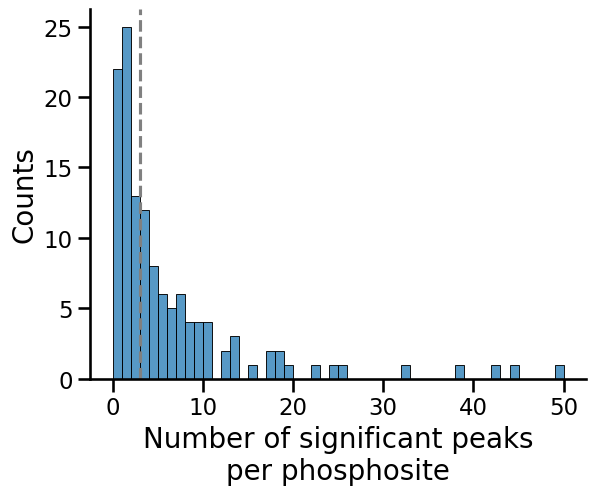

In [286]:
# Change ticks and stuff
sns.set_context("talk")
sns.histplot(list(psite_to_number_of_peaks.values()),bins=50)
plt.axvline(np.median(peak_number_per_psite),ls='--', color='gray')
plt.xlabel("Number of significant peaks\nper phosphosite",fontsize=20)
plt.ylabel("Counts",fontsize=20)
sns.despine()
plt.savefig(out_path / "histogram_peaks_per_phosphosite.pdf",dpi=120,bbox_inches='tight')


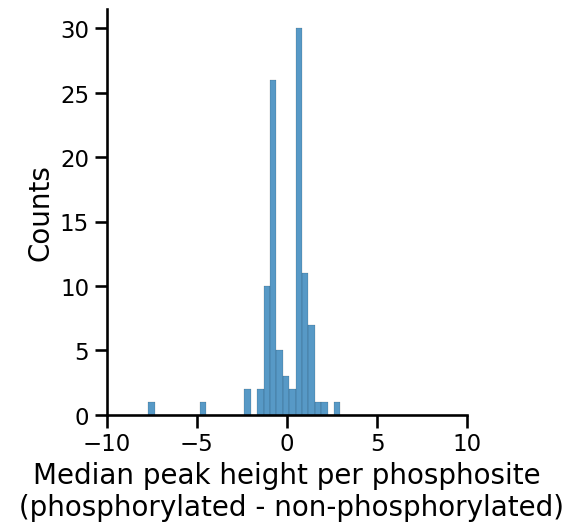

In [285]:
sns.set_context("talk")
sns.displot(list(psite_to_median_peak_height.values()),bins=300)
#plt.axvline(np.median([np.abs(x) for x in median_peak_height_per_psite]))

plt.xlabel("Median peak height per phosphosite\n (phosphorylated - non-phosphorylated)",fontsize=20)
plt.ylabel("Counts",fontsize=20)
plt.xlim(-10,10)
sns.despine()
plt.savefig(out_path / "histogram_peak_heights_per_phosphosite.pdf",dpi=120,bbox_inches='tight')



In [100]:
# Calculate, per phosphosite, the number of significant peaks and the median height of the peak
psite_local_peaks_df = []
columns = ['phosphosite','peak_number','median_peak_height']
for k, number_of_peaks in psite_to_number_of_peaks.items():
    try:
        median_peak_height = psite_to_median_peak_height[k]
    except KeyError:
        median_peak_height = float('nan')
    psite_local_peaks_df.append([k, number_of_peaks, median_peak_height])
psite_local_peaks_df = pd.DataFrame(psite_local_peaks_df, columns=columns)

Text(0.5, 0, 'Number of significant peaks per phosphosite')

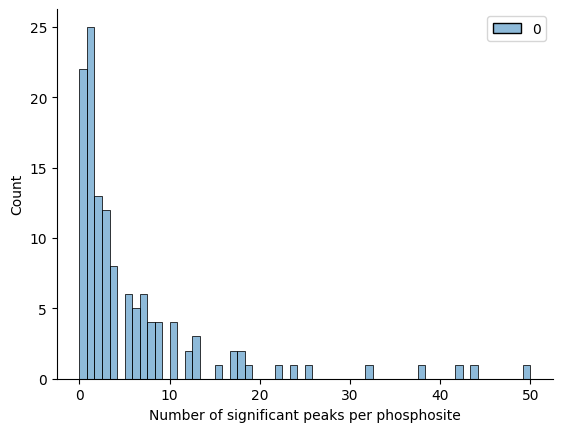

In [105]:
sns.histplot(psite_to_number_of_peaks.values(),color='black',bins=60)
sns.despine()
plt.xlabel('Number of significant peaks per phosphosite')

Text(0.5, 9.444444444444438, 'Median peak height')

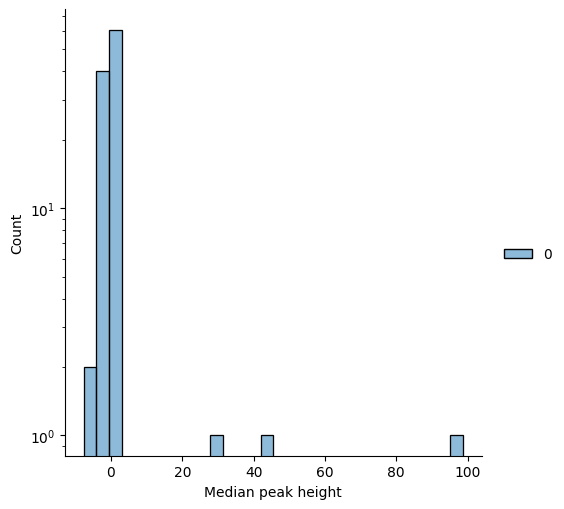

In [106]:
sns.displot(psite_to_median_peak_height.values(),color='black',bins=30)
plt.yscale('log')
plt.xlabel('Median peak height')

## How many phosphosites have statistically significant changes in their local dynamics?
Compare the ranks of residue fluctuations

In [118]:
test_wilcoxon_pvals = {}

p_sample_sizes = []
np_sample_sizes = []
aln_length = []
median_diffs = []
median_fcs = []

aln_lens = []

for psite in p_fluctuations.keys():
    
    p_sqflucts = p_fluctuations[psite]
    np_sqflucts = np_fluctuations[psite]
    
    if len(p_sqflucts) > 0 and len(np_sqflucts) > 0:

        p_local_medians = np.median(np.vstack(p_sqflucts), axis=0)
        np_local_medians = np.median(np.vstack(np_sqflucts), axis=0)
        diffs = p_local_medians - np_local_medians
        fcs = np.log2(p_local_medians / np_local_medians)

        median_diffs.append(np.median(diffs))
        median_fcs.append(np.median(fcs))
        aln_len = p_sqflucts[0].shape[0]
        aln_lens.append(aln_len)
        p_sample_sizes.append(len(p_sqflucts))
        np_sample_sizes.append(len(np_sqflucts))
        
        statistic, pval = wilcoxon(diffs)
        test_wilcoxon_pvals[psite] = pval

adj_pvals = multipletests(list(test_wilcoxon_pvals.values()), alpha=0.05, method='fdr_bh')

local_dynamics_df = []
columns = ['phosphosite','reject','adj_pval','phospho_sample_size',
           'nonphospho_sample_size', 'alignment_size','median_diff','median_log2fc']

for idx, psite in enumerate(test_wilcoxon_pvals.keys()):
    
    reject = adj_pvals[0][idx]
    adj_pval = adj_pvals[1][idx]
    
    p_sample = p_sample_sizes[idx]
    np_sample = np_sample_sizes[idx]

    row = [psite, reject, adj_pval, p_sample_sizes[idx], np_sample_sizes[idx], aln_lens[idx], median_diffs[idx],median_fcs[idx]]
    local_dynamics_df.append(row)

local_dynamics_df = pd.DataFrame(local_dynamics_df, columns=columns)
local_dynamics_df.sort_values(by='adj_pval',inplace=True)
local_dynamics_df["log_adj_pval"] = -np.log10(local_dynamics_df["adj_pval"])
local_dynamics_df.to_csv(out_path / "local_dynamics_df.csv")

In [117]:
# What fraction of phosphosites have statistically significant changes?
sum(local_dynamics_df["reject"]==True)/len(local_dynamics_df)

0.8046875

In [119]:
# Prepare plotting
local_sig_colors = []
direction_change = []
sig_threshold = -np.log10(0.05)
for idx, row in local_dynamics_df.iterrows():
    if (row["log_adj_pval"] > sig_threshold) and (row["median_log2fc"] > 0):
        local_sig_colors.append('tab:red')
        direction_change.append('increase')
    elif (row["log_adj_pval"] > sig_threshold) and (row["median_log2fc"] < 0):
        local_sig_colors.append('tab:blue')
        direction_change.append('decrease')
    else:
        local_sig_colors.append('gray')
        direction_change.append('no change')

## Combine both approaches

In [120]:
joint_local_dynamics_df = psite_local_peaks_df.merge(local_dynamics_df, on='phosphosite')
joint_local_dynamics_df["abs_median_peak_height"] = abs(joint_local_dynamics_df["median_peak_height"])
joint_local_dynamics_df.to_csv(out_path / "joint_local_dynamics_df.csv",index=None)

In [158]:
local_dynamics_colors = []
direction_change = []
sig = 0
for idx, row in joint_local_dynamics_df.iterrows():
    adj_pval = row['adj_pval']
    median_peak_height = row['median_peak_height']
    
    if adj_pval < 0.05 and median_peak_height > 0:
        local_dynamics_colors.append('red')
        direction_change.append('increase')
        sig+=1
    elif adj_pval < 0.05 and median_peak_height < 0:
        local_dynamics_colors.append('blue')
        direction_change.append('decrease')
        sig+=1
    else:
        local_dynamics_colors.append('gray')
        direction_change.append('no_change')

joint_local_dynamics_df['colors'] = local_dynamics_colors
joint_local_dynamics_df['direction_change'] = direction_change
joint_local_dynamics_df_nona = joint_local_dynamics_df.dropna()

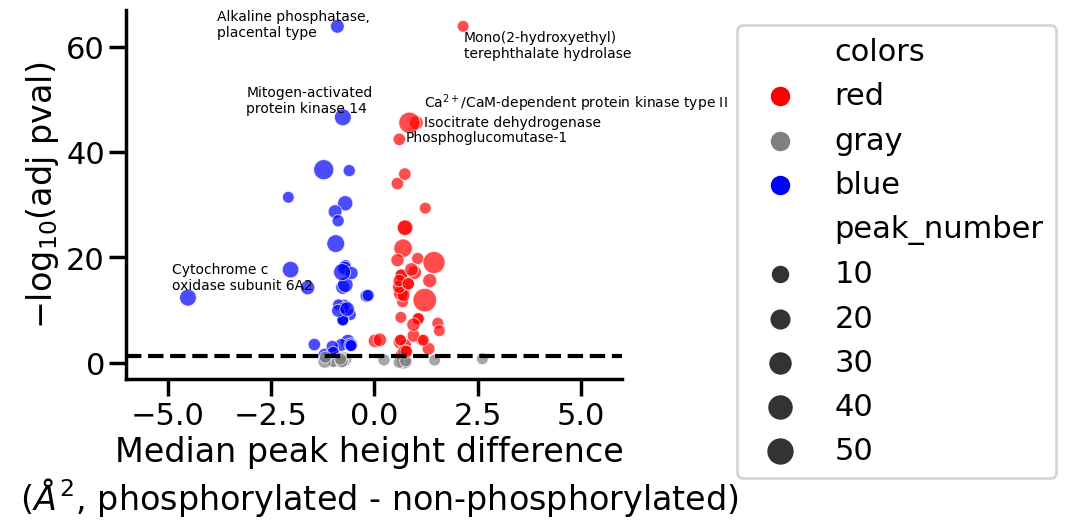

In [167]:
sns.set_context('poster')
ax = sns.scatterplot(data=joint_local_dynamics_df_nona, x='median_peak_height',y='log_adj_pval',
                size='peak_number',hue='colors',alpha=.7,palette=['red','gray','blue'])
plt.axhline(sig_threshold,c='black',ls='--')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1.2, 1))

plt.xlabel('Median peak height difference \n ($Å^2$, phosphorylated - non-phosphorylated)')
plt.ylabel("$-\log_{10}$(adj pval)")
sns.despine()
plt.xlim(-6,6)

plt.text(-4.9,14,"Cytochrome c\noxidase subunit 6A2",fontsize=10)
# A0A0K8P8E7_225 - peak probably far away from the psite
plt.text(2.16,58,"Mono(2-hydroxyethyl)\nterephthalate hydrolase",fontsize=10)
# P05187_114 - phosphoserine intermediate
plt.text(-3.8,62, "Alkaline phosphatase,\nplacental type",fontsize=10)
# P08200_113
plt.text(1.2, 45, "Isocitrate dehydrogenase",fontsize=10)
# P47811_182
plt.text(-3.1, 47.595, "Mitogen-activated\nprotein kinase 14",fontsize=10)
# O62305_284
plt.text(1.2,48.55, r"Ca$^{2+}$/CaM-dependent protein kinase type II",fontsize=10)
# P36871_117
plt.text(0.75, 42, "Phosphoglucomutase-1",fontsize=10)


plt.savefig(out_path / 'local_dynamics_scatterplot.pdf',dpi=120,bbox_inches='tight')

In [ ]:
joint_local_dynamics_df

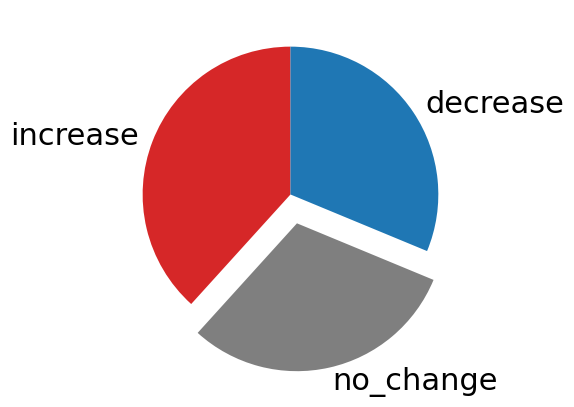

In [178]:
direction_counter = Counter(joint_local_dynamics_df['direction_change'])

values =  list(direction_counter.values())
labels = list(direction_counter.keys())
colors = ["tab:red","tab:gray","tab:blue"]
explode = [0,0.2,0]

plt.pie(values, labels = labels, startangle = 90,explode=explode, colors=colors)
plt.savefig(out_path / "local_dynamics_changes_piechart.pdf",dpi=120,bbox_inches='tight')